# Data understanding

We will analyze the *titanic* dataset:

* to realize what information we have (statistical units, variables)
* to check data quality and reliability of data
* to understand distributions of variables and their relationships
* to suggest steps for data cleaning
* to suggest useful data transformations

## 0. What is our goal?

Analysis of date comes out from the goal of the **business understanding**. So first we set that goal:

> We analyse Titanic data to find out how survival for each passenger can be predicted from his or her attributes.

Let's start with loading data and making a quick overview.

In [21]:
### Setup
%matplotlib inline
# should enable plotting without explicit call .show()

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# classes for special types
from pandas.api.types import CategoricalDtype

# Apply the default theme
sns.set_theme()

# Reading and inspecting data
df = pd.read_csv("titanic_train.csv")
df

,passenger_id,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1216,3,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,13,NaN,NaN,1
1,699,3,"Cacic, Mr. Luka",male,38.0,0,0,315089,8.6625,NaN,S,NaN,NaN,Croatia,0
2,1267,3,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",female,30.0,1,1,345773,24.1500,NaN,S,NaN,NaN,NaN,0
3,449,2,"Hocking, Mrs. Elizabeth (Eliza Needs)",female,54.0,1,3,29105,23.0000,NaN,S,4,NaN,"Cornwall / Akron, OH",1
4,576,2,"Veal, Mr. James",male,40.0,0,0,28221,13.0000,NaN,S,NaN,NaN,"Barre, Co Washington, VT",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,158,1,"Hipkins, Mr. William Edward",male,55.0,0,0,680,50.0000,C39,S,NaN,NaN,London / Birmingham,0
846,174,1,"Kent, Mr. Edward Austin",male,58.0,0,0,11771,29.7000,B37,C,NaN,258.0,"Buffalo, NY",0
847,467,2,"Kantor, Mrs. Sinai (Miriam Sternin)",female,24.0,1,0,244367,26.0000,NaN,S,12,NaN,"Moscow / Bronx, NY",1
848,1112,3,"Peacock, Miss. Treasteall",female,3.0,1,1,SOTON/O.Q. 3101315,13.7750,NaN,S,NaN,NaN,NaN,0


## 1. Basic overview of the data

1. Rows: How many? What are statistical units? How can a unit be identified?
2. Columns: How many? What are their names, types, meanings? At the first glance, do values seem plausible? Are all of them useful for our purpose?

Summary: do we need to carry out any initial transformations? (i. e. to make a sample of rows or columns; to convert column names to lowercase; to provide a column with ID; to remove some columns etc.)

In [22]:
print(df.shape) # count of rows and columns
# units are passengers, it seems they can be identified by passenger_id
# but are passenger_id unique?
print(df[["passenger_id"]].nunique()) # nunique method, DataFrame with one column only
print(len(np.unique(df["passenger_id"]))) # other way using NumPy unique function
# number of unique values is equal to number of rows => ok

(850, 15)
passenger_id    850
dtype: int64
850


In [23]:
# column names and types
print(df.dtypes)
# names are in lowercase, meaningful and short, no need to adjust

# column meaning
# at the first sight, meaning is clear and values seem plausible for all
# - except sibsp, parch, embarked, boat, body
# we have to get an explanation or extra info - can be found on the Internet
# sibsp: Number of siblings/spouses aboard
# parch: Number of parents/children aboard
# embarked: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
# boat: Lifeboat
# body: Body Identification Number

# all columns seem to be useful for our goal

# column types
# all types seem proper except body and boat (we expect integer if it is id number)
# moreover the variable *embarked* could be ordered (the order of stops is S, C, Q)
# let's consider it later, at the moment of variable inspection

passenger_id      int64
pclass            int64
name             object
sex              object
age             float64
sibsp             int64
parch             int64
ticket           object
fare            float64
cabin            object
embarked         object
boat             object
body            float64
home.dest        object
survived          int64
dtype: object


## 2. Checking the data quality

* Are there any duplicated rows (with exclusion of ID)?
* What are counts and shares of missing values in the dataset columns?
* Are counts of missing values expectable and acceptable?
* Are any columns or rows (almost) empty and may be removed as useless?
* In which columns should we consider fixing of values (correction, filling)?

In [24]:
# duplicated rows?
sum(df.duplicated(subset=['pclass', 'name', 'sex', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest',
       'survived']))
# 0 duplicated rows

0

In [25]:
# counts of missing values
# absolute counts: len(df) - df.count()
# relative counts (shares):
print(1 - df.count()/len(df))

# occurences of missings: age (rather a lot => problem), fare and embarked (1 case each - no much problem),
# - cabin, boat and body (high but expectable => no much problem),
# - home.dest (around a half but maybe not important)

# the most important variable *survived* is available for all records
# => no need to remove rows
# some columns contain much missing values but still may be useful
# - we can use the fact of missingness as a variable/feature
# - (e. g. for *cabin* or *boat*)

# *age*, *fare* and *embarked* deserve fixing

passenger_id    0.000000
pclass          0.000000
name            0.000000
sex             0.000000
age             0.204706
sibsp           0.000000
parch           0.000000
ticket          0.000000
fare            0.001176
cabin           0.775294
embarked        0.001176
boat            0.637647
body            0.914118
home.dest       0.454118
survived        0.000000
dtype: float64


In [26]:
# rows with many missing values
df.count(axis=1).value_counts()

# no row is complete but this is not surprising (*boat* and *body* are sparse)
# minimum of non-missing is 10 - looks like we have no "almost empty" rows

12    265
11    189
13    169
14    121
10    106
dtype: int64

After all these check we can do a summary about data quality and make recommendations for preprocessing (cleaning, fixing) data. Some of them can be done immediately if it is necessary or may be useful for the analysis.

In [27]:
# the variable *embarked* could be ordered (the order of stops is S, C, Q)
embarked_type = CategoricalDtype(categories=["S", "C", "Q"], ordered=True)
df["embarked"] = df["embarked"].astype(embarked_type)

## 3. Checking variable distributions

It's a good idea to start with the most important variables: the target one (*survived*) and the ones we expect to provide great information for the target one while being complete (*sex*, *pclass*, *fare*, *embarked*). Then we go to variables which are more complicated or need a fixing (*age*).

For each of those six variables above, try to do following:

* Make descriptive statistics of the distribution and a proper graph.
* Consider if the distribution is expectable and seems plausible (no strange or obviously invalid values).
* If the variable has missing values, try to figure out reasons of it and to suggest a fixing, if necessary.

          count  count_cum  count_rel  count_relcum
embarked                                           
S           589        589   0.693757      0.693757
C           176        765   0.207303      0.901060
Q            84        849   0.098940      1.000000


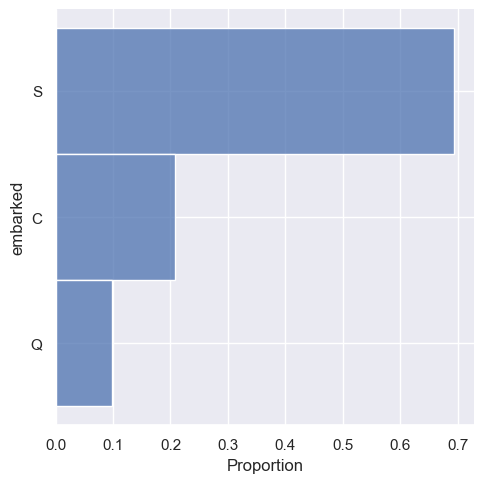

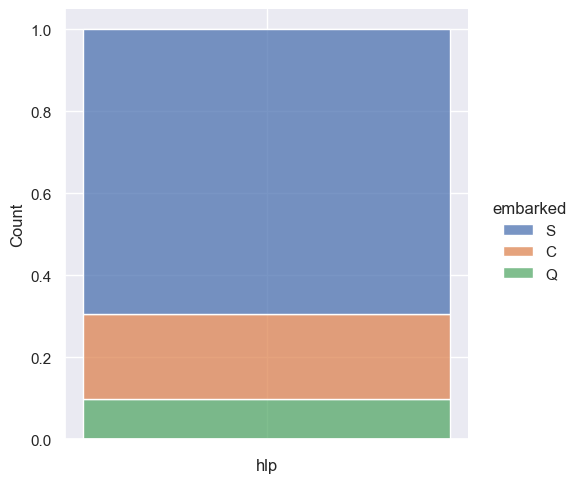

In [28]:
# Example: embarked
# frequency table
freqtab = df.groupby("embarked").agg(count=("passenger_id", "count")) # absolute frequencies (counts)
freqtab["count_cum"] = freqtab["count"].cumsum() # cumulative frequencies
freqtab["count_rel"] = freqtab["count"] / sum(freqtab["count"]) # relative frequencies
freqtab["count_relcum"] = freqtab["count_rel"].cumsum() # cumulative relative frequencies
print(freqtab)

# graph
g = sns.displot(data=df, y="embarked", stat="proportion") # relative frequencies directly from DataFrame

# for stacked barplot, we use frequency table computed above
g = sns.displot(data=freqtab.assign(hlp=""),
                x="hlp", hue="embarked", multiple="stack", weights="count_rel")

In [32]:
# one missing value - attempt to fix
# who has an empty *embarked*?
print(df[df["embarked"].isna()])
# did she share the ticket or the cabin with anyone else?
print(df[df["ticket"]=="113572"])
print(df[df["cabin"]=="B28"])
# unfortunately, no one else travelled on that ticket or in that cabin

# we can try to estimate embarkment place by fare, class and cabin first letter
df[(df["pclass"]==1) & (df["cabin"].str.slice(stop=1) == "B")]
# there is a big share of Cherbourg embarkment among females with similar fare and "B" cabins
# so we can fill "C" for the case with missing *embarked* value

     passenger_id  pclass                 name     sex   age  sibsp  parch  \
109           168       1  Icard, Miss. Amelie  female  38.0      0      0   

     ticket  fare cabin embarked boat  body home.dest  survived  
109  113572  80.0   B28      NaN    6   NaN       NaN         1  
     passenger_id  pclass                 name     sex   age  sibsp  parch  \
109           168       1  Icard, Miss. Amelie  female  38.0      0      0   

     ticket  fare cabin embarked boat  body home.dest  survived  
109  113572  80.0   B28      NaN    6   NaN       NaN         1  
     passenger_id  pclass                 name     sex   age  sibsp  parch  \
109           168       1  Icard, Miss. Amelie  female  38.0      0      0   

     ticket  fare cabin embarked boat  body home.dest  survived  
109  113572  80.0   B28      NaN    6   NaN       NaN         1  


,passenger_id,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
37,249,1,"Ryerson, Master. John Borie",male,13.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,4,NaN,"Haverford, PA / Cooperstown, NY",1
57,142,1,"Guggenheim, Mr. Benjamin",male,46.0,0,0,PC 17593,79.2000,B82 B84,C,NaN,NaN,"New York, NY",0
59,55,1,"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,S,4,NaN,"Bryn Mawr, PA",1
60,50,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C,3,NaN,"Germantown, Philadelphia, PA",1
72,57,1,"Carter, Mrs. William Ernest (Lucile Polk)",female,36.0,1,2,113760,120.0000,B96 B98,S,4,NaN,"Bryn Mawr, PA",1
95,150,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0000,B94,S,NaN,110.0,NaN,0
109,168,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN,6,NaN,NaN,1
114,170,1,"Ismay, Mr. Joseph Bruce",male,49.0,0,0,112058,0.0000,B52 B54 B56,S,C,NaN,Liverpool,1
160,83,1,"Crosby, Mrs. Edward Gifford (Catherine Elizabe...",female,64.0,1,1,112901,26.5500,B26,S,7,NaN,"Milwaukee, WI",1
169,193,1,"Madill, Miss. Georgette Alexandra",female,15.0,0,1,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1


In [40]:
df[df["ticket"] == "113572"]

,passenger_id,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
109,168,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,6,NaN,NaN,1


## 4. Analysis of relationships

The last part of this practice section is to analyze relationship between variables. Check how is *survival* related to each of five remaining variables considered in the previous part (*sex*, *pclass*, *fare*, *embarked*, *age*).

        surv_class
pclass            
1         0.606796
2         0.457831
3         0.234310


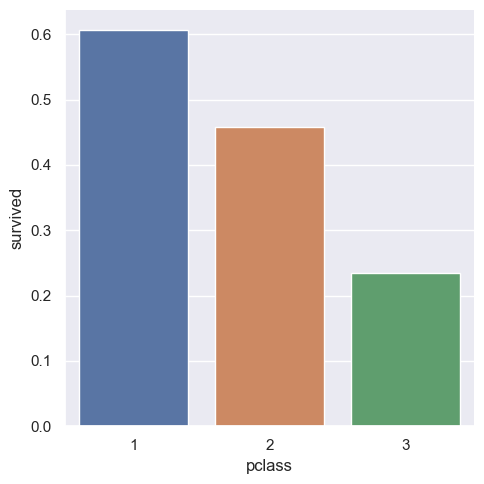

In [30]:
# Example: survival by class
print(df.groupby("pclass").agg(surv_class=("survived", "mean")))
g = sns.catplot(data=df, x="pclass", y="survived", kind="bar", errorbar=None)